In [1]:
import glob
import os
import lxml.etree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Extracting Structured Data from ParlaMint-PT (TEI XML)

In this step, we parse the ParlaMint-PT TEI-encoded parliamentary debates and transform them into a structured format suitable for analysis.  
The result is stored in a pandas DataFrame where each row corresponds to a single utterance (<u> element) in the corpus.  

In [2]:
# Path to your TEI files
tei_path = r"C:\Users\Joana & Sofia\Documents\Ju\NOVA SBE\Thesis\ParlaMint-PT.TEI"

# Load speaker metadata if listPerson.xml exists
speakers_dict = {}
persons_file = os.path.join(tei_path, "ParlaMint-PT-listPerson.xml")
if os.path.exists(persons_file):
    tree = ET.parse(persons_file)
    root = tree.getroot()
    for person in root.findall(".//{*}person"):
        pid = person.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

        # Full name, clean whitespace and join all text parts
        name_el = person.find(".//{*}persName")
        name = " ".join(name_el.itertext()).replace("\n", " ").split() if name_el is not None else pid
        name = " ".join(name)

        # Gender
        sex_el = person.find(".//{*}sex")
        gender = sex_el.attrib.get("value") if sex_el is not None else "Unknown"

        # Party
        affil_el = person.find(".//{*}affiliation")
        party_id = affil_el.attrib.get("ref", "Unknown") if affil_el is not None else "Unknown"
        party_name_el = affil_el.find(".//{*}orgName") if affil_el is not None else None
        party_name = party_name_el.text.strip() if party_name_el is not None else party_id

        speakers_dict[pid] = {
            "name": name,
            "gender": gender,
            "party_id": party_id,
            "party_name": party_name
        }

# Find all session XML files
files = glob.glob(os.path.join(tei_path, "20*/**/*.xml"), recursive=True)
print(f"Found {len(files)} XML files.")

data = []

for f in files:
    if "Schema" in f:
        continue  # Skip schema files

    try:
        tree = ET.parse(f)
        root = tree.getroot()

        # Session metadata
        session_id = root.attrib.get("{http://www.w3.org/XML/1998/namespace}id", os.path.basename(f))
        session_title_el = root.find(".//{*}title")
        session_title = session_title_el.text.strip() if session_title_el is not None and session_title_el.text else "Unknown"

        # Extract year from session_id (ParlaMint-PT_YYYY-MM-DD)
        try:
            year = session_id.split("_")[1].split("-")[0]
        except:
            year = "Unknown"

        # Date: fallback to <date> if available
        date_el = root.find(".//{*}date")
        if date_el is not None and date_el.attrib.get("when"):
            session_date = date_el.attrib.get("when")
        else:
            # Use session_id date if <date> is missing
            session_date = "_".join(session_id.split("_")[1:])

        # Utterances
        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

            speaker_id = u.attrib.get("who")
            speaker_id = speaker_id.lstrip("#") if speaker_id else "Unknown"

            speech_type = u.attrib.get("ana", "Unknown")
            lang = u.attrib.get("{http://www.w3.org/XML/1998/namespace}lang", "pt")

            # Get speaker info
            speaker_info = speakers_dict.get(
                speaker_id,
                {"name": speaker_id, "gender": "Unknown", "party_id": "Unknown", "party_name": "Unknown"}
            )

            # Combine <seg> text
            text = " ".join(seg.text.strip() for seg in u.findall(".//{*}seg") if seg.text)
            word_count = len(text.split())

            data.append([
                speech_id, session_id, session_title, session_date, year,
                speaker_id, speaker_info["name"], speaker_info["party_id"], speaker_info["party_name"],
                speaker_info["gender"], speech_type, lang,
                word_count, text
            ])

    except Exception as e:
        print(f"⚠️ Error parsing {f}: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=[
    "speech_id", "session_id", "session_title", "date", "year",
    "speaker_id", "speaker_name", "party_id", "party_name",
    "gender", "speech_type", "language",
    "word_count", "text"
])

# Preview
print(df.head(10))

# Optionally save to CSV
# df.to_csv("ParlaMint_PT_corpus_all_years.csv", index=False)


Found 901 XML files.
                     speech_id               session_id  \
0   ParlaMint-PT_2015-01-07.u1  ParlaMint-PT_2015-01-07   
1   ParlaMint-PT_2015-01-07.u2  ParlaMint-PT_2015-01-07   
2   ParlaMint-PT_2015-01-07.u3  ParlaMint-PT_2015-01-07   
3   ParlaMint-PT_2015-01-07.u4  ParlaMint-PT_2015-01-07   
4   ParlaMint-PT_2015-01-07.u5  ParlaMint-PT_2015-01-07   
5   ParlaMint-PT_2015-01-07.u6  ParlaMint-PT_2015-01-07   
6   ParlaMint-PT_2015-01-07.u7  ParlaMint-PT_2015-01-07   
7   ParlaMint-PT_2015-01-07.u8  ParlaMint-PT_2015-01-07   
8   ParlaMint-PT_2015-01-07.u9  ParlaMint-PT_2015-01-07   
9  ParlaMint-PT_2015-01-07.u10  ParlaMint-PT_2015-01-07   

                                       session_title        date  year  \
0  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2015   
1  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2015   
2  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2015   
3  Corpus parlamentar português P

In [3]:
# --- Add BELOW your existing code ---

from collections import defaultdict, Counter
import xml.etree.ElementTree as ET

# Collect per-speech non-verbal events
event_counts = defaultdict(Counter)
event_texts  = defaultdict(list)

def normalize_label(v_type, v_text):
    """Map TEI <vocal>/<incident> to normalized labels."""
    vt = (v_type or "").lower()
    vx = (v_text or "").lower()
    # Portuguese & English cues
    if any(k in vt for k in ["applause", "aplauso", "aplausos"]) or any(k in vx for k in ["aplaus", "aplauso"]):
        return "applause"
    if any(k in vt for k in ["laughter", "risos", "riso"]) or any(k in vx for k in ["risos", "riso", "laughter"]):
        return "laughter"
    if any(k in vt for k in ["shout", "boo", "cheer", "aclama"]) or any(k in vx for k in ["grito", "gritos", "apupos", "aclama"]):
        return "shout"
    if any(k in vt for k in ["interrupt"]) or any(k in vx for k in ["interrup"]):
        return "interruption"
    return None

for f in files:
    if "Schema" in f:
        continue
    try:
        tree = ET.parse(f)
        root = tree.getroot()

        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")
            if not speech_id:
                continue

            # <vocal> (applause, laughter, shouts, etc.)
            for voc in u.findall(".//{*}vocal"):
                v_type = voc.attrib.get("type") or voc.attrib.get("ana")
                v_text = "".join(voc.itertext()).strip()
                label = normalize_label(v_type, v_text)
                if label:
                    event_counts[speech_id][label] += 1
                    # Only show readable markers for key labels
                    if label in ("applause", "laughter", "shout"):
                        event_texts[speech_id].append(f"[{label.capitalize()}]")
                else:
                    event_counts[speech_id]["vocal_other"] += 1

            # <incident> (interruptions, noise, etc.)
            for inc in u.findall(".//{*}incident"):
                i_type = inc.attrib.get("type") or inc.attrib.get("ana")
                i_text = "".join(inc.itertext()).strip()
                label = normalize_label(i_type, i_text)
                if label == "interruption":
                    event_counts[speech_id]["interruption"] += 1
                    event_texts[speech_id].append("[Interruption]")
                else:
                    event_counts[speech_id]["incident_other"] += 1

    except Exception as e:
        print(f"⚠️ Error scanning events in {f}: {e}")

# Build a DataFrame with event counts and markers
events_df = pd.DataFrame(
    [
        {
            "speech_id": sid,
            "applause_count": cnts.get("applause", 0),
            "laughter_count": cnts.get("laughter", 0),
            "shout_count": cnts.get("shout", 0),
            "interruption_count": cnts.get("interruption", 0),
            "vocal_other_count": cnts.get("vocal_other", 0),
            "incident_other_count": cnts.get("incident_other", 0),
            "events_text": " ".join(event_texts[sid]),
        }
        for sid, cnts in event_counts.items()
    ]
)

# Merge with your existing df, keep original columns intact
df_enriched = df.merge(events_df, on="speech_id", how="left")

# Fill NaNs for new columns and create a convenience text with events
for col in ["applause_count","laughter_count","shout_count",
            "interruption_count","vocal_other_count","incident_other_count"]:
    if col in df_enriched.columns:
        df_enriched[col] = df_enriched[col].fillna(0).astype(int)

df_enriched["events_text"] = df_enriched["events_text"].fillna("")
df_enriched["text_with_events"] = (
    df_enriched["text"].fillna("") + " " + df_enriched["events_text"]
).str.strip()

# Quick peek
print(df_enriched[["speech_id","speaker_name","party_name",
                   "applause_count","laughter_count","shout_count","interruption_count",
                   "text_with_events"]].head(10))


                     speech_id                           speaker_name  \
0   ParlaMint-PT_2015-01-07.u1      Maria da Assunção Andrade Esteves   
1   ParlaMint-PT_2015-01-07.u2   Duarte Rogério Matos Ventura Pacheco   
2   ParlaMint-PT_2015-01-07.u3      Maria da Assunção Andrade Esteves   
3   ParlaMint-PT_2015-01-07.u4                     Abel Lima Baptista   
4   ParlaMint-PT_2015-01-07.u5      Maria da Assunção Andrade Esteves   
5   ParlaMint-PT_2015-01-07.u6              Pedro Filipe Gomes Soares   
6   ParlaMint-PT_2015-01-07.u7      Maria da Assunção Andrade Esteves   
7   ParlaMint-PT_2015-01-07.u8                António Costa Rodrigues   
8   ParlaMint-PT_2015-01-07.u9      Maria da Assunção Andrade Esteves   
9  ParlaMint-PT_2015-01-07.u10  João Guilherme Ramos Rosa de Oliveira   

  party_name  applause_count  laughter_count  shout_count  interruption_count  \
0       #PSD               0               0            0                   0   
1       #PSD               0      

In [4]:
# Example: print the first row completely
print(df.iloc[0].to_string())

speech_id                               ParlaMint-PT_2015-01-07.u1
session_id                                 ParlaMint-PT_2015-01-07
session_title    Corpus parlamentar português ParlaMint-PT, Sér...
date                                                    2025-06-20
year                                                          2015
speaker_id                           MariadaAssunçãoAndradeEsteves
speaker_name                     Maria da Assunção Andrade Esteves
party_id                                                      #PSD
party_name                                                    #PSD
gender                                                           F
speech_type                                     #chair topic:other
language                                                        pt
word_count                                                      82
text             Srs. Deputados, Srs. Jornalistas, Srs. Funcion...


## Overview of the Dataset

C:\Temp\ipykernel_23992\263497237.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=speech_counts.index, y=speech_counts.values, palette="viridis")


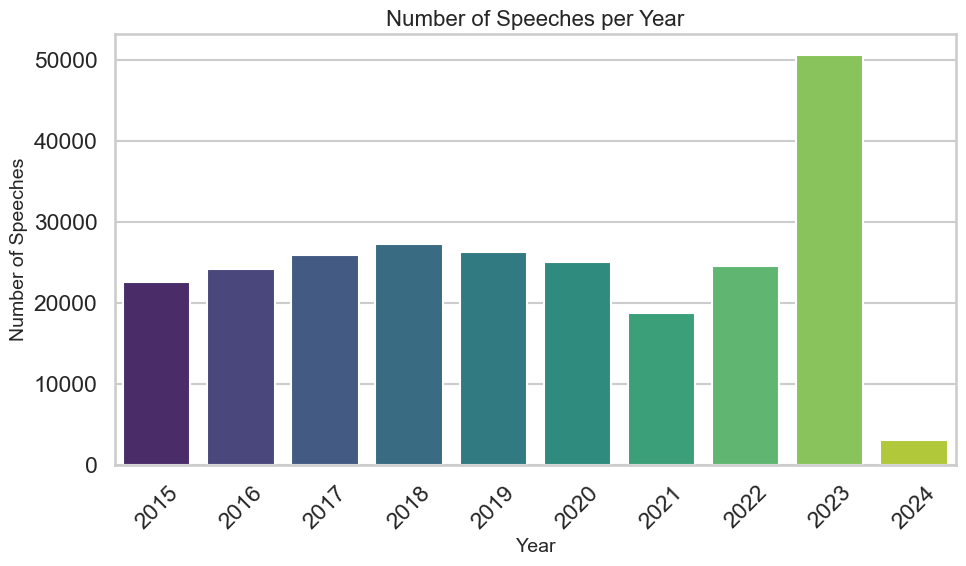

In [5]:
# Set Seaborn style
sns.set(style="whitegrid", context="talk", palette="muted")

# ----- Graph 1: Number of speeches per year -----
plt.figure(figsize=(10,6))
speech_counts = df.groupby('year')['speech_id'].count().sort_index()
sns.barplot(x=speech_counts.index, y=speech_counts.values, palette="viridis")
plt.title("Number of Speeches per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Speeches", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



*Interpretation:*

The graph shows the speech distribution from 2015 until 13th of March 2024. In the histogram we can see that in 2023 is substatially higher than in all other years. In 2024, we only have the speeches for the first two and half months, that is why the count of speeches is lower.

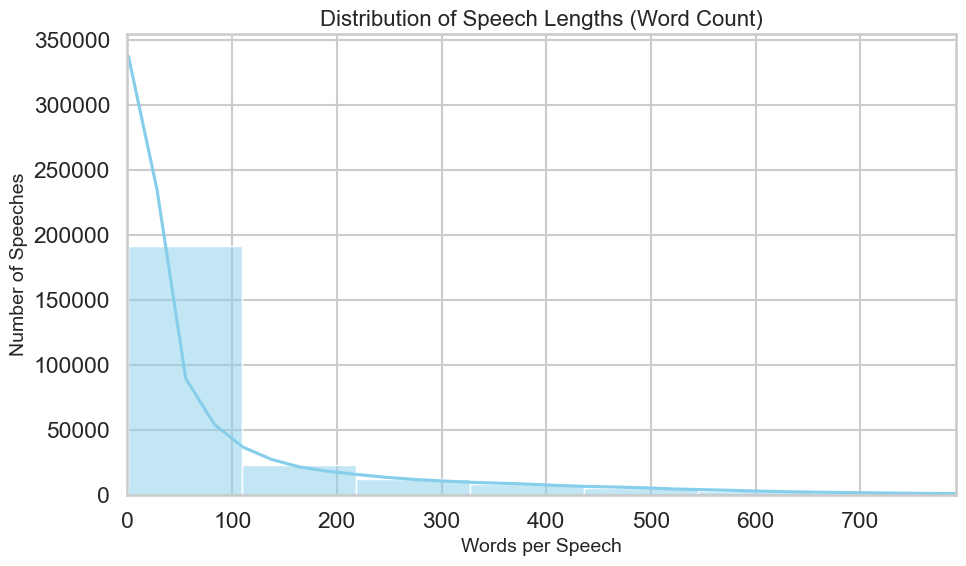

In [6]:
# ----- Graph 2: Distribution of speech lengths -----
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Speech Lengths (Word Count)", fontsize=16)
plt.xlabel("Words per Speech", fontsize=14)
plt.ylabel("Number of Speeches", fontsize=14)
plt.xlim(0, df['word_count'].quantile(0.99))  # limit x-axis to 99th percentile to avoid long tails
plt.tight_layout()
plt.show()


*Interpretation:*

The distribution of speech lenght (word count) is positively skewed. In the graph we can se that the speech lenght for the majority of the speeches is only 100 words. That “pile-up around ~100 words” is mostly an artifact, not a real “most speeches are ~100 words” fact. A few things are happening at once:
- Parliaments have tons of very short interventions (procedural remarks, “Aplausos.”, heckles). Those dominate the counts and create a huge first few bins.
- Your bins are wide and the x-axis is truncated at P99, so a lot of mass gets squeezed toward the left visually.

Therefore, we ploted the graph below.

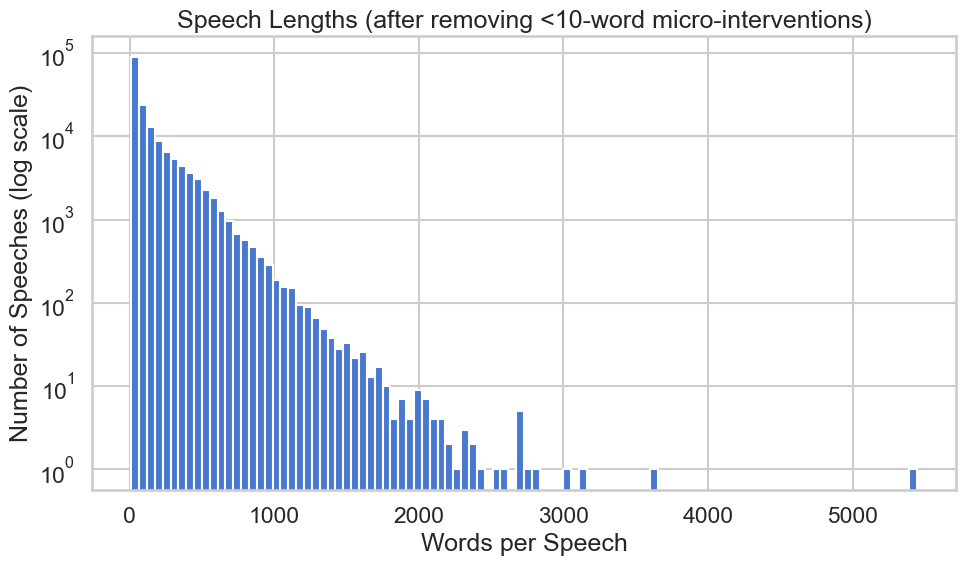

In [7]:
# ----- Graph 2.1: Distribution of speech lengths (after removing <10-word micro-interventions) -----

# 1) sanity check the distribution
df['word_count'].describe(percentiles=[.5, .75, .9, .95, .99])

# Look at examples of ultra-short "speeches"
df.loc[df['word_count'] <= 5, 'text'].head(20)

# 2) simple cleaning: drop ultra-short micro-interventions
df_clean = df[df['word_count'] >= 10].copy()

# 3) use narrower bins and log Y to handle skew; avoid KDE
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_clean['word_count'], bins=100)
plt.yscale('log')                        # log count helps you see the tail
plt.title("Speech Lengths (after removing <10-word micro-interventions)")
plt.xlabel("Words per Speech")
plt.ylabel("Number of Speeches (log scale)")
plt.tight_layout()
plt.show()



*Interpretation:*

Key features of the new plot:
- Log scale on Y-axis: Instead of the first few bins dwarfing everything, you now see the entire shape of the distribution. Most speeches are still short (a few dozen to a few hundred words), but you can also see the long right tail of speeches that go into the thousands of words.
- Removed <10-word micro-interventions: This filters out “noise” like applause markers or one-liner heckles that aren’t meaningful speeches. That’s why the huge spike at very low word counts disappeared.
- Heavy-tailed / approximately power-law behavior: The straight-ish line on the log plot indicates that very long speeches become exponentially rarer, but they do exist (some >5000 words).

Differences with the previous graph:
- Previous graph (linear scale, included micro-speeches):
    - Huge spike at very low word counts made it look like “most speeches are ~100 words.”
    - KDE curve was misleading, smoothing over a very discrete, skewed distribution.
    - The long tail was invisible because everything was crushed to the left.
- New graph (log scale, micro-speeches removed):
    - Shows the true shape: many short speeches, fewer medium-length, and a very long but small tail.
    - You can now distinguish between short interventions (10–200 words), typical speeches (200–1000), and rare marathon speeches (>2000).
    - It’s interpretable for both central tendency and extremes.


A KDE curve stands for Kernel Density Estimate curve. It’s a way of estimating the probability density function of your data — basically, it’s like a smooth version of a histogram.

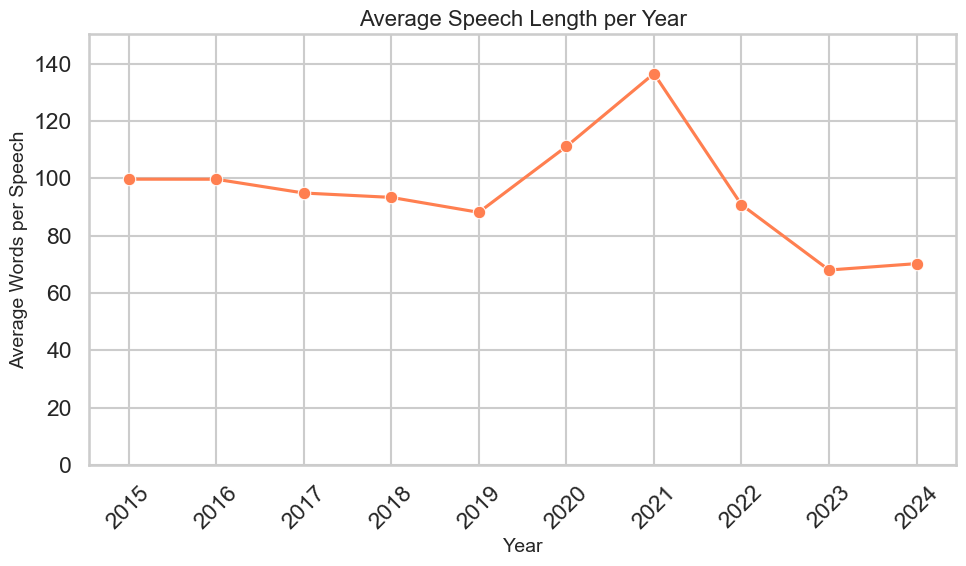

In [8]:
# ----- Graph 3: Compute average speech length per year -----

avg_length = df.groupby('year')['word_count'].mean().sort_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=avg_length.index, y=avg_length.values, marker="o", color="coral")
plt.title("Average Speech Length per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Words per Speech", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, avg_length.max()*1.1)  # Add a little space above max
plt.tight_layout()
plt.show()

*Interpretation:*

- Stable period (2015–2019): Suggests normal parliamentary routines, with average speeches being short interventions.

- Spike in 2020–2021: Could be linked to exceptional circumstances — e.g., pandemic-related debates, major budgetary/legislative discussions, or heightened political polarization. MPs may have delivered longer, more substantive speeches.

- Decline after 2021: Average speech lengths drop significantly. Possible reasons:
    - More micro-interventions relative to longer speeches.
    - Procedural or political shifts (e.g., faster-paced debates, increased interruptions).
    - New parties entering parliament with different speaking styles (shorter, more frequent interventions).

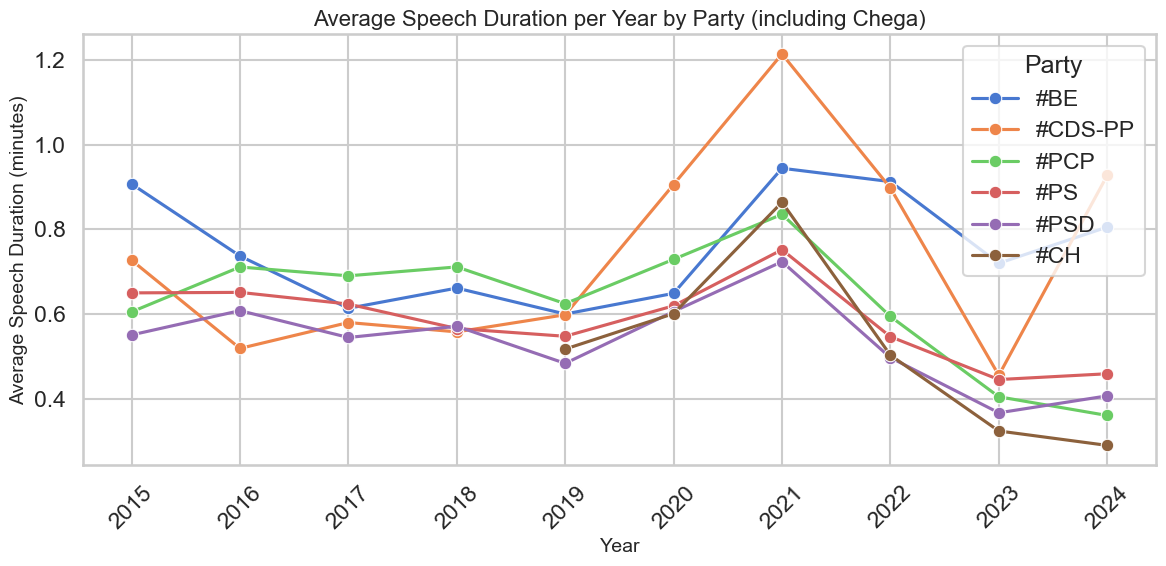

In [9]:
# ----- Graph 4: Average Speech Duration per Year by Party (including Chega) -----

# Make sure we have minutes
df['minutes'] = df['word_count'] / 150

# Average speech duration per year & party
avg_minutes_by_party_year = (
    df.groupby(['year','party_name'])['minutes']
      .mean()
      .reset_index()
)

# Pick top N parties + Chega
top_parties = df['party_name'].value_counts().head(5).index.tolist()
if "#CH" not in top_parties:
    top_parties.append("#CH")

plot_data = avg_minutes_by_party_year[avg_minutes_by_party_year['party_name'].isin(top_parties)]

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=plot_data,
    x='year', y='minutes',
    hue='party_name', marker="o"
)
plt.title("Average Speech Duration per Year by Party (including Chega)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Speech Duration (minutes)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Party")
plt.tight_layout()
plt.show()


*Interpretation:*
- BE: Starts as the party with longest speeches (2015), then declines, rises again in 2020–2021, and stabilizes around ~0.8 min by 2024.
- CDS-PP: The most dramatic swing — from ~0.7 min in 2015 to 1.2 min peak in 2021, then collapsing in 2023, but strongly rebounding in 2024.
- PCP: Fairly stable until 2019, rises in 2020–2021 (~0.7–0.8 min), but then declines sharply to ~0.35 min by 2024.
- PS & PSD: Similar trajectories — steady until 2019, rise in 2020–2021, sharp fall after 2021, modest recovery in 2024 (but still below 2015–2017 levels).
- Chega (CH): Enters in 2019 with ~0.6 min, follows the general peak in 2020–2021, but then declines steeply, reaching the shortest average speech length (0.3 min) in 2024.

In [10]:
print(df.shape)   # number of rows, columns
print(df.info())  # column types, missing values
print(df['party_name'].value_counts().head(10))  # most frequent parties
print(df['gender'].value_counts())


(248577, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248577 entries, 0 to 248576
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   speech_id      248577 non-null  object 
 1   session_id     248577 non-null  object 
 2   session_title  248577 non-null  object 
 3   date           248577 non-null  object 
 4   year           248577 non-null  object 
 5   speaker_id     248577 non-null  object 
 6   speaker_name   248577 non-null  object 
 7   party_id       248577 non-null  object 
 8   party_name     248577 non-null  object 
 9   gender         248577 non-null  object 
 10  speech_type    248577 non-null  object 
 11  language       248577 non-null  object 
 12  word_count     248577 non-null  int64  
 13  text           248577 non-null  object 
 14  minutes        248577 non-null  float64
dtypes: float64(1), int64(1), object(13)
memory usage: 28.4+ MB
None
party_name
#PS        87370
#PSD       545

C:\Temp\ipykernel_23992\1445595219.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=party_counts.index, y=party_counts.values, palette="mako")


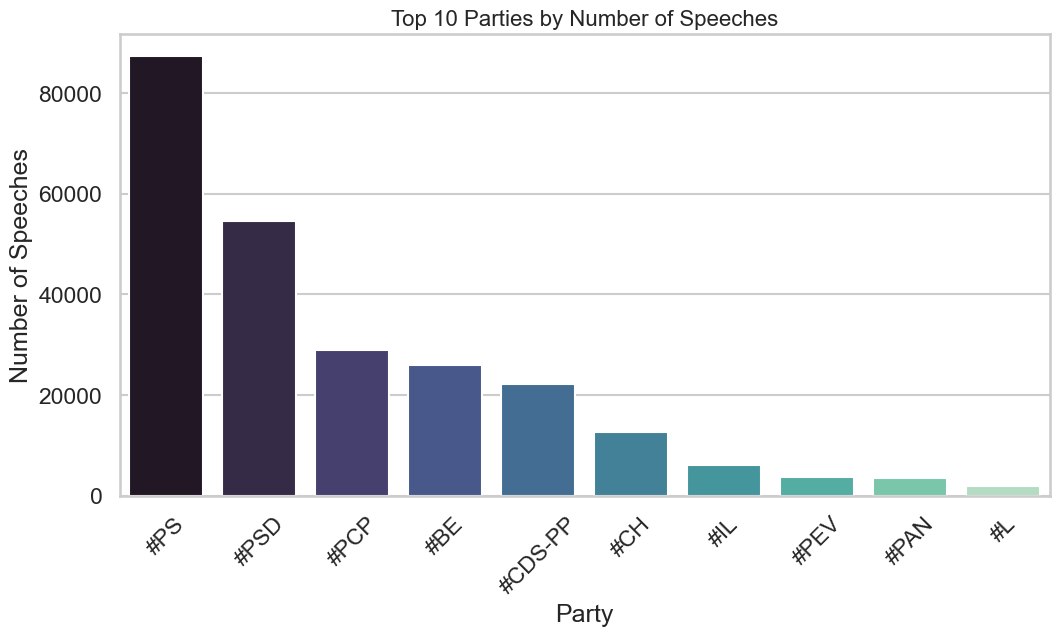

C:\Temp\ipykernel_23992\1445595219.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=party_minutes.index, y=party_minutes.values, palette="mako")


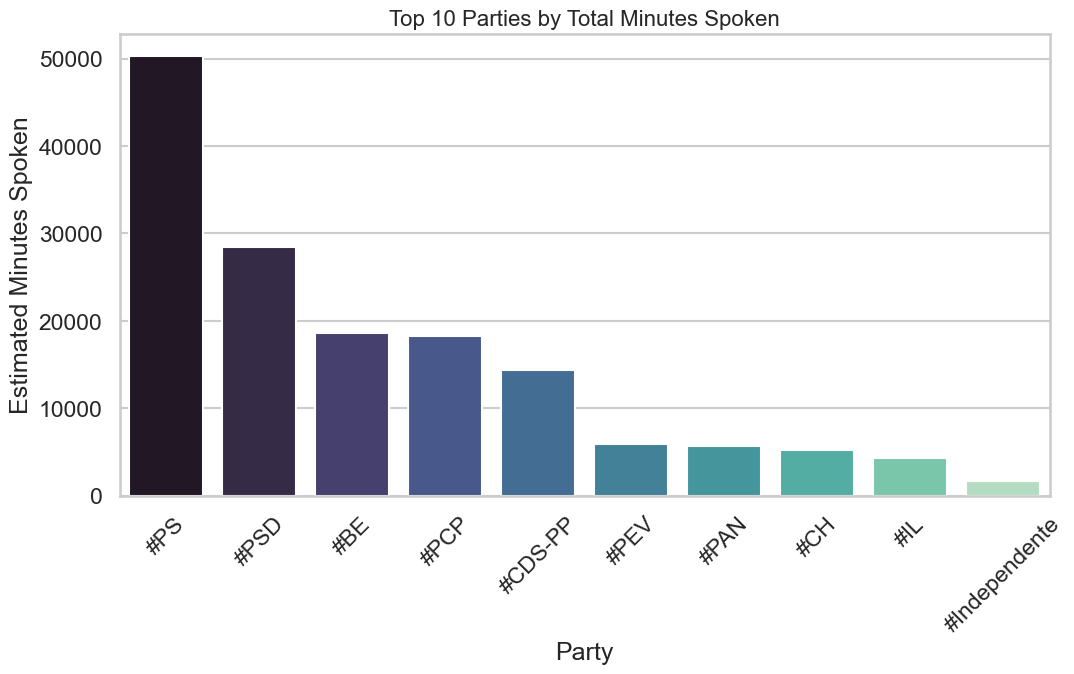

In [11]:
# ----- Graph 5: Top 10 parties by number of speeches -----
plt.figure(figsize=(12,6))
party_counts = df['party_name'].value_counts().head(10)  # top 10 parties
sns.barplot(x=party_counts.index, y=party_counts.values, palette="mako")
plt.title("Top 10 Parties by Number of Speeches", fontsize=16)
plt.ylabel("Number of Speeches")
plt.xlabel("Party")
plt.xticks(rotation=45)
plt.show()

# Add column for estimated minutes
df['minutes'] = df['word_count'] / 150

# Sum minutes by party
party_minutes = df.groupby('party_name')['minutes'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=party_minutes.index, y=party_minutes.values, palette="mako")
plt.title("Top 10 Parties by Total Minutes Spoken", fontsize=16)
plt.ylabel("Estimated Minutes Spoken")
plt.xlabel("Party")
plt.xticks(rotation=45)
plt.show()


*Interpretation:*

The graph show the top 10 Portuguese parties by number of speeches and minutes spoken in the parliament. Mostly the parties in both graphs match.

The distribution of speeches closely tracks party size and parliamentary influence: larger and governing parties (PS, PSD) dominate, mid-sized ideological parties (PCP, BE, CDS-PP) take a significant share, and newcomers (CH, IL) are punching above their historical weight given their short time in parliament.

Chega stands out: although it only entered in 2019, it has already overtaken older small parties (PEV, PAN, Livre) in number of speeches by far, but not by number of minutes spoken, signaling that it has frequent short interventions.

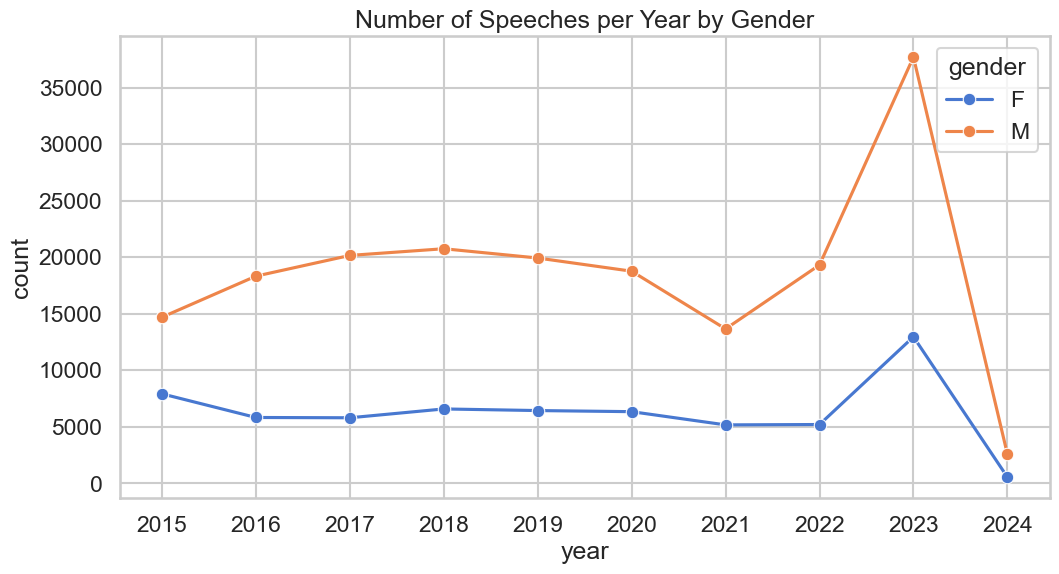

In [12]:
gender_by_year = df.groupby(['year','gender']).size().reset_index(name='count')
plt.figure(figsize=(12,6))
sns.lineplot(data=gender_by_year, x='year', y='count', hue='gender', marker="o")
plt.title("Number of Speeches per Year by Gender")
plt.show()


*Interpretation:*

- There is an overall imbalance.
- Male MPs (M) consistently deliver far more speeches than female MPs (F) throughout the period.
- The gap is very wide: usually ~3x more male speeches than female speeches.

C:\Temp\ipykernel_23992\2767157944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="crest")


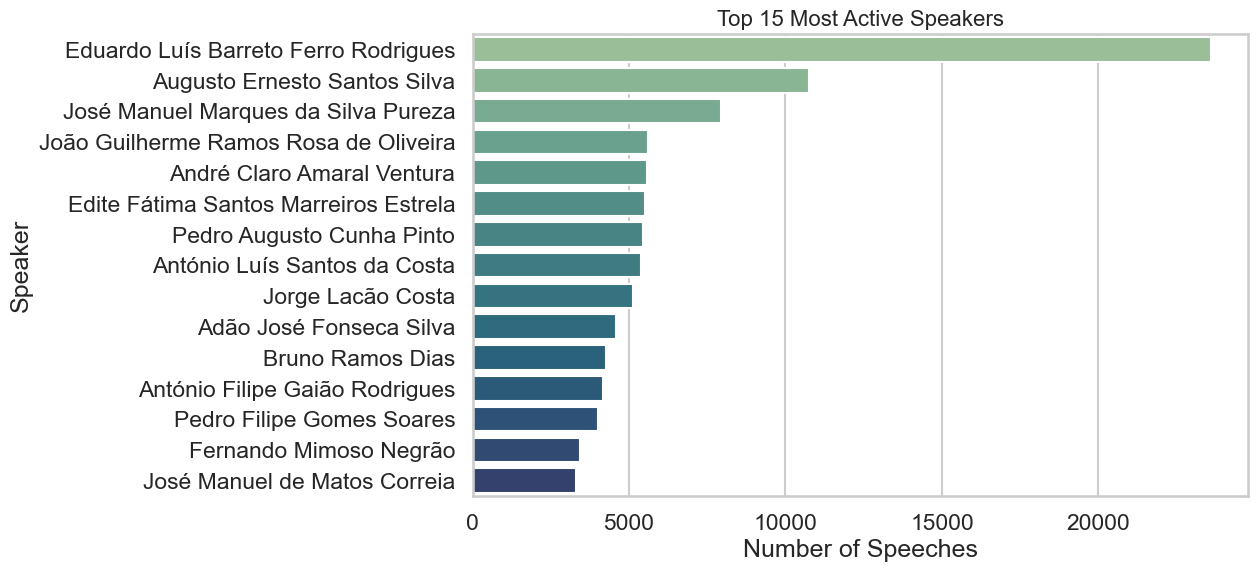

In [13]:
top_speakers = df['speaker_name'].value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="crest")
plt.title("Top 15 Most Active Speakers", fontsize=16)
plt.xlabel("Number of Speeches")
plt.ylabel("Speaker")
plt.show()


*Interpretation:*

The ranking reflects not just political activism but also institutional role + leadership status + career length. Ferro Rodrigues’ huge lead highlights how the Speaker of Parliament, by moderating nearly every session, becomes by far the most frequent “speaker” in raw counts.

- Institutional roles drive speech counts: Presidents of the Assembly and government leaders (e.g., Ferro Rodrigues, Santos Silva, António Costa) dominate due to procedural interventions and frequent participation.
- Party leaders stand out: Figures like André Ventura (CH), António Costa (PS), and Pedro Filipe Soares (BE) use speeches strategically to assert leadership and visibility.
- Longevity matters: MPs with long parliamentary careers accumulate high totals over time, explaining why many of these names are senior figures.

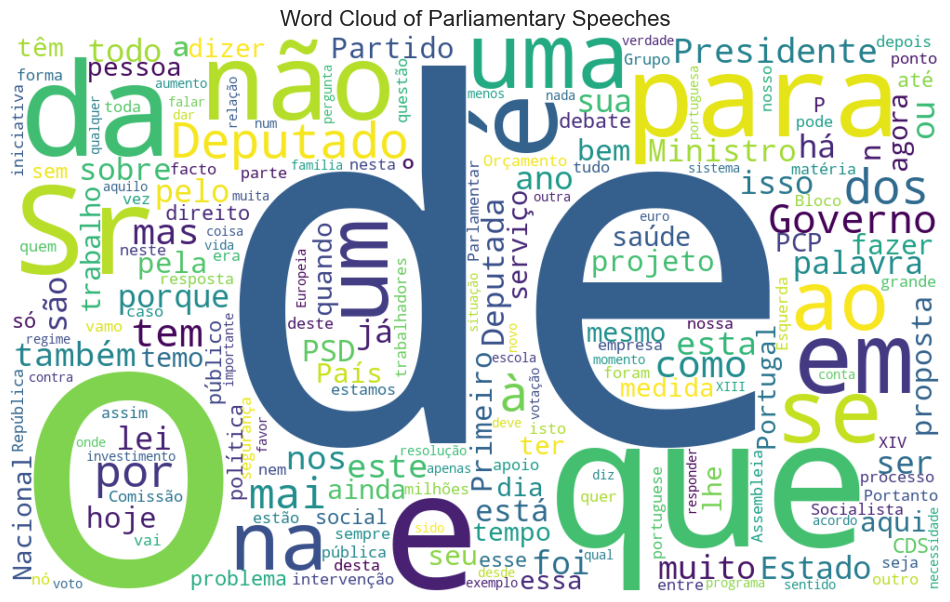

In [14]:
from wordcloud import WordCloud

text_all = " ".join(df['text'].dropna().sample(5000, random_state=42))  # sample to save memory
wc = WordCloud(width=1000, height=600, background_color="white", collocations=False).generate(text_all)

plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Parliamentary Speeches", fontsize=16)
plt.show()


## Chega Deepdive


In [15]:
sns.set(style="whitegrid", context="talk")

# Minutes ≈ words / 150 (speech rate)
if 'minutes' not in df.columns:
    df['minutes'] = df['word_count'] / 150.0

# Clean year for sorting
df['year_num'] = pd.to_numeric(df['year'], errors='coerce')

# Robust Chega filter (party_id or party_name can be '#CH' / 'CH' / 'Chega')
is_ch = (
    df['party_id'].str.upper().str.contains('CH', na=False) |
    df['party_name'].str.upper().str.contains('CHEGA|^#CH$', na=False)
)
ch = df[is_ch].copy()

print(f"Total speeches: {len(df):,} | Chega speeches: {len(ch):,}")

Total speeches: 248,577 | Chega speeches: 12,670


### 1: How big is Chega’s presence? (counts, minutes, shares)

 year_num  total_speeches  total_minutes  ch_speeches  ch_minutes  share_speeches_%  share_minutes_%  ch_avg_minutes
     2015           22601       15022.27          0.0        0.00              0.00             0.00            0.00
     2016           24142       16043.19          0.0        0.00              0.00             0.00            0.00
     2017           25949       16412.27          0.0        0.00              0.00             0.00            0.00
     2018           27322       17002.25          0.0        0.00              0.00             0.00            0.00
     2019           26358       15485.95        135.0       69.87              0.51             0.45            0.52
     2020           25094       18587.25        921.0      553.67              3.67             2.98            0.60
     2021           18821       17132.30        526.0      454.51              2.79             2.65            0.86
     2022           24512       14835.35       3157.0     1588.5

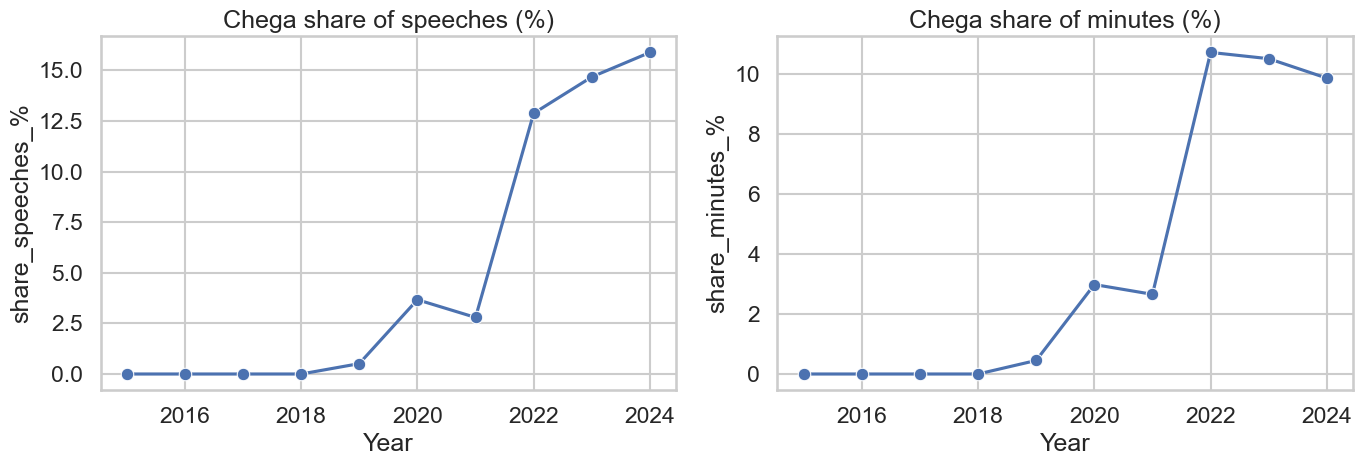

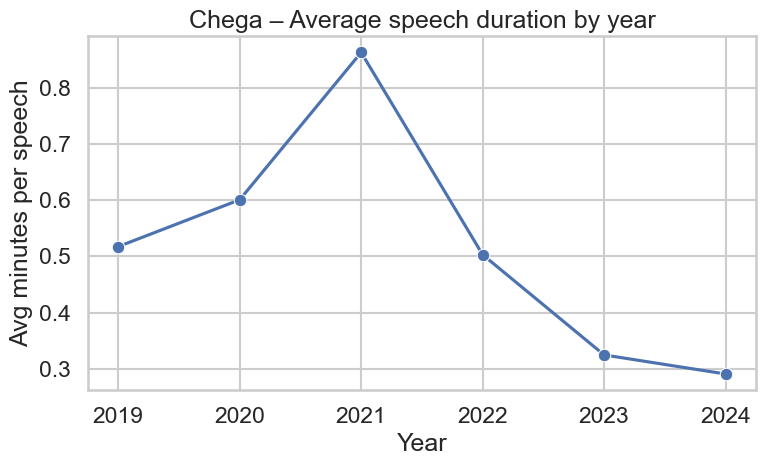

In [16]:
# Per-year totals
totals = (df.dropna(subset=['year_num'])
            .groupby('year_num')
            .agg(total_speeches=('speech_id','count'),
                 total_minutes=('minutes','sum'))
            .reset_index())

ch_year = (ch.dropna(subset=['year_num'])
             .groupby('year_num')
             .agg(ch_speeches=('speech_id','count'),
                  ch_minutes=('minutes','sum'),
                  ch_avg_minutes=('minutes','mean'))
             .reset_index())

mix = totals.merge(ch_year, on='year_num', how='left').fillna(0)
mix['share_speeches_%'] = 100*mix['ch_speeches']/mix['total_speeches']
mix['share_minutes_%']  = 100*mix['ch_minutes']/mix['total_minutes']

display_cols = ['year_num','total_speeches','total_minutes','ch_speeches','ch_minutes',
                'share_speeches_%','share_minutes_%','ch_avg_minutes']
print(mix[display_cols].round(2).to_string(index=False))

# Share of minutes & speeches over time
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.lineplot(data=mix, x='year_num', y='share_speeches_%', marker='o', ax=ax[0])
ax[0].set_title("Chega share of speeches (%)"); ax[0].set_xlabel("Year")
sns.lineplot(data=mix, x='year_num', y='share_minutes_%', marker='o', ax=ax[1])
ax[1].set_title("Chega share of minutes (%)"); ax[1].set_xlabel("Year")
plt.tight_layout(); plt.show()

# Average speech duration (minutes) for Chega over years
plt.figure(figsize=(8,5))
sns.lineplot(data=ch_year, x='year_num', y='ch_avg_minutes', marker='o')
plt.title("Chega – Average speech duration by year")
plt.xlabel("Year"); plt.ylabel("Avg minutes per speech"); plt.tight_layout(); plt.show()


*Interpretation:*

1. Chega’s share of speeches (%)
- 2019–2020: Starts small (~0.5% → ~3–4%).
- 2021: Dips slightly (~2.5%).
- 2022 onwards: Explodes — jumps to ~13% in 2022 and rises further to ~16% in 2024.
Interpretation: Chega quickly established itself as a major contributor in terms of number of interventions, showing a strategy of high-frequency, visibility-focused participation.

2. Chega’s share of minutes (%)
- 2019–2020: Climbs from near zero to ~3%.
- 2021: Small dip (~2.5%).
- 2022: Big leap — >10% of total speaking time, before stabilizing slightly lower (~9–10%).
Interpretation: Chega is not just speaking more often, but also taking up a substantial share of overall floor time, rivaling much older parties.

3. Chega’s average speech duration (minutes)
- 2019–2020: Speeches average ~0.5–0.6 minutes (short interventions).
- 2021: Peaks at ~0.85 minutes (longer speeches, perhaps linked to big debates/elections).
- 2022–2024: Steep decline — average speeches shorten to 0.3 minutes in 2024.
Interpretation: After an initial phase of longer interventions, Chega shifted to a strategy of many short speeches, boosting its share of interventions but reducing their average length.

Combined interpretation, Chega’s strategy evolved:
- Early years (2019–2021): Fewer but longer interventions, establishing presence.
- Post-2022: A pivot to short, frequent interventions, maximizing visibility and share of speeches.
- Impact on parliament: By 2022–2024, Chega accounts for 15–16% of all speeches but only ~10% of speaking time. This mismatch reflects their style: more interruptions, procedural remarks, and short interventions rather than lengthy floor speeches.
- Political implication: This pattern fits populist party tactics — dominating attention through volume, even if individual contributions are short.

### 2: Who speaks for Chega? (top speakers, totals & averages)


Top 15 Chega speakers by total minutes:
                                               speeches  minutes  avg_minutes
speaker_name                                                                 
André Claro Amaral Ventura                         5561  2745.53         0.49
Pedro Saraiva Gonçalves dos Santos Frazão          2154   460.09         0.21
Bruno Miguel de Oliveira Nunes                     1328   434.33         0.33
Rita Maria Cid Matias                              1090   352.99         0.32
António Filipe Dias Melo Peixoto                   1166   296.72         0.25
Rui Pedro da Silva Afonso                           278   224.05         0.81
Gabriel Sérgio Mithá Ribeiro                        311   169.64         0.55
Rui Paulo Duque Sousa                               227   166.81         0.73
Jorge Manuel de Valsassina Galveias Rodrigues       276   166.41         0.60
Diogo Velez Mouta Pacheco de Amorim                 184   106.20         0.58
Pedro Manuel de Andrade

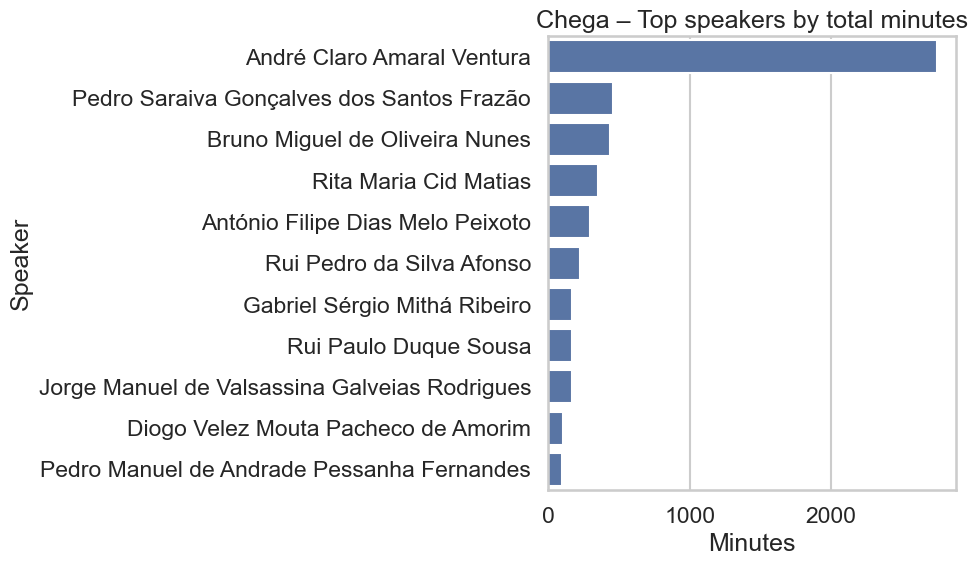


Longest 10 Chega speeches:
             session_id                    speech_id               speaker_name  word_count   minutes       date
ParlaMint-PT_2021-06-23  ParlaMint-PT_2021-06-23.u55 André Claro Amaral Ventura        2305 15.366667 2025-06-20
ParlaMint-PT_2022-09-23  ParlaMint-PT_2022-09-23.u12 André Claro Amaral Ventura        1734 11.560000 2025-06-20
ParlaMint-PT_2021-06-23  ParlaMint-PT_2021-06-23.u67 André Claro Amaral Ventura        1485  9.900000 2025-06-20
ParlaMint-PT_2022-05-27 ParlaMint-PT_2022-05-27.u107 André Claro Amaral Ventura        1472  9.813333 2025-06-20
ParlaMint-PT_2021-06-23   ParlaMint-PT_2021-06-23.u4 André Claro Amaral Ventura        1445  9.633333 2025-06-20
ParlaMint-PT_2022-04-25  ParlaMint-PT_2022-04-25.u12 André Claro Amaral Ventura        1398  9.320000 2025-06-20
ParlaMint-PT_2022-10-27 ParlaMint-PT_2022-10-27.u524 André Claro Amaral Ventura        1391  9.273333 2025-06-20
ParlaMint-PT_2022-01-06  ParlaMint-PT_2022-01-06.u32 André Claro Ama

In [17]:
# Totals by speaker
ch_speakers = (ch.groupby('speaker_name')
                 .agg(speeches=('speech_id','count'),
                      minutes=('minutes','sum'),
                      avg_minutes=('minutes','mean'))
                 .sort_values('minutes', ascending=False))

print("\nTop 15 Chega speakers by total minutes:")
print(ch_speakers.head(15).round(2).to_string())

# Plot top 12 by total minutes
top_spk = ch_speakers.head(12).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_spk, y='speaker_name', x='minutes')
plt.title("Chega – Top speakers by total minutes"); plt.xlabel("Minutes"); plt.ylabel("Speaker")
plt.tight_layout(); plt.show()

# Longest single speeches (by words/minutes)
longest = ch.sort_values('word_count', ascending=False)[
    ['session_id','speech_id','speaker_name','word_count','minutes','date']
].head(10)
print("\nLongest 10 Chega speeches:")
print(longest.to_string(index=False))


*Interpretation:*

The graph shows the distribution of minutes spoken by Chega by the Chega speakers.


Chega speakers normalized by ACTIVE years (minutes/active-year):
                                               active_years  minutes  minutes_per_active_year  speeches  speeches_per_active_year
speaker_name                                                                                                                     
André Claro Amaral Ventura                                6  2745.53                   457.59      5561                    926.83
Pedro Saraiva Gonçalves dos Santos Frazão                 3   460.09                   153.36      2154                    718.00
Bruno Miguel de Oliveira Nunes                            3   434.33                   144.78      1328                    442.67
Rita Maria Cid Matias                                     3   352.99                   117.66      1090                    363.33
António Filipe Dias Melo Peixoto                          3   296.72                    98.91      1166                    388.67
Rui Pedro da Silva Afons

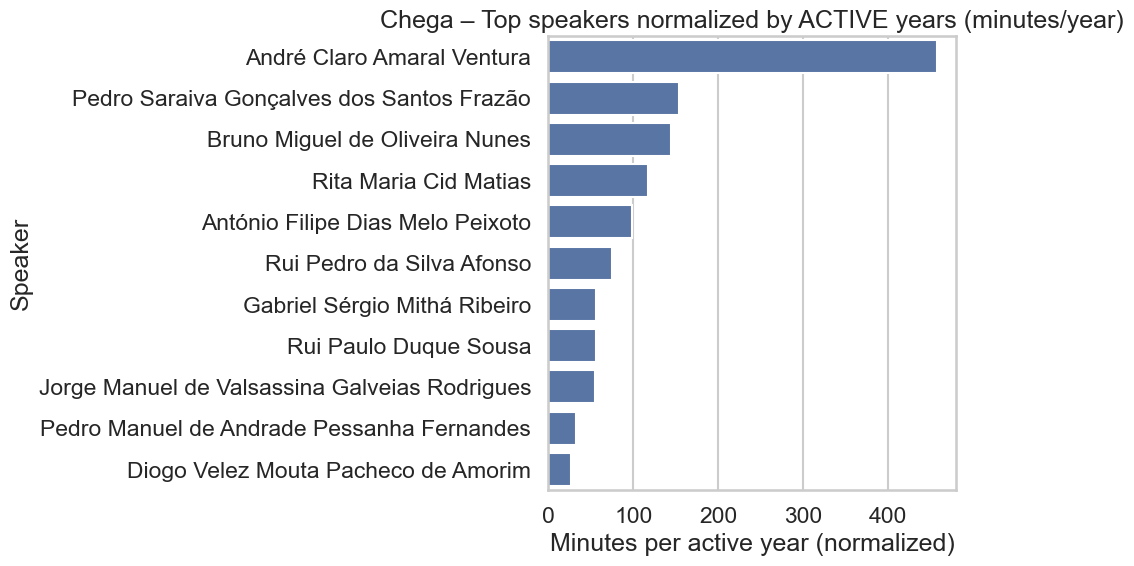

In [18]:
ch_totals = (
    ch.groupby('speaker_name', dropna=False)
      .agg(minutes=('minutes','sum'),
           speeches=('speech_id','count'))
)

active_years = (
    df[df['year_num'].notna()]
      .groupby('speaker_name')['year_num']
      .nunique()
      .rename('active_years')
)

stats_active = (
    ch_totals.join(active_years, how='left')
             .assign(active_years=lambda d: d['active_years'].fillna(1))
             .assign(
                 minutes_per_active_year=lambda d: d['minutes'] / d['active_years'],
                 speeches_per_active_year=lambda d: d['speeches'] / d['active_years']
             )
             .sort_values('minutes_per_active_year', ascending=False)
)

print("\nChega speakers normalized by ACTIVE years (minutes/active-year):")
print(
    stats_active[['active_years','minutes','minutes_per_active_year','speeches','speeches_per_active_year']]
    .head(15).round(2).to_string()
)

# Plot
top_active = stats_active.head(12).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_active, y='speaker_name', x='minutes_per_active_year')
plt.title("Chega – Top speakers normalized by ACTIVE years (minutes/year)")
plt.xlabel("Minutes per active year (normalized)")
plt.ylabel("Speaker")
plt.tight_layout()
plt.show()

*Interpretation:*


The graph shows the distribution of minutes spoken by Chega by the Chega speakers, weighted with the number of years each speaker has been in the parlament. André Ventura stil dominates with far more minutes than any other Chega MP.

- Ventura-centered strategy: The graph shows that Chega’s parliamentary communication is highly centralized around André Ventura, who dominates floor time.
- Support cast: Other MPs intervene, but their contributions are small in comparison, suggesting their role is supportive rather than leading.
- Party dynamics: This pattern contrasts with more established parties where speaking time is more evenly distributed among MPs. It underlines Chega’s personalized, leader-driven style of politics.

### 4: What does Chega talk about? (topics from speech_type)


Top Chega topics (by number of speeches):
topic
other    6158
macro     866
mixed     802
healt     694
gover     586
civil     518
lawcr     478
educa     419
inter     303
housi     265
labor     239
welfa     218
immig     199
argic     172
trans     172


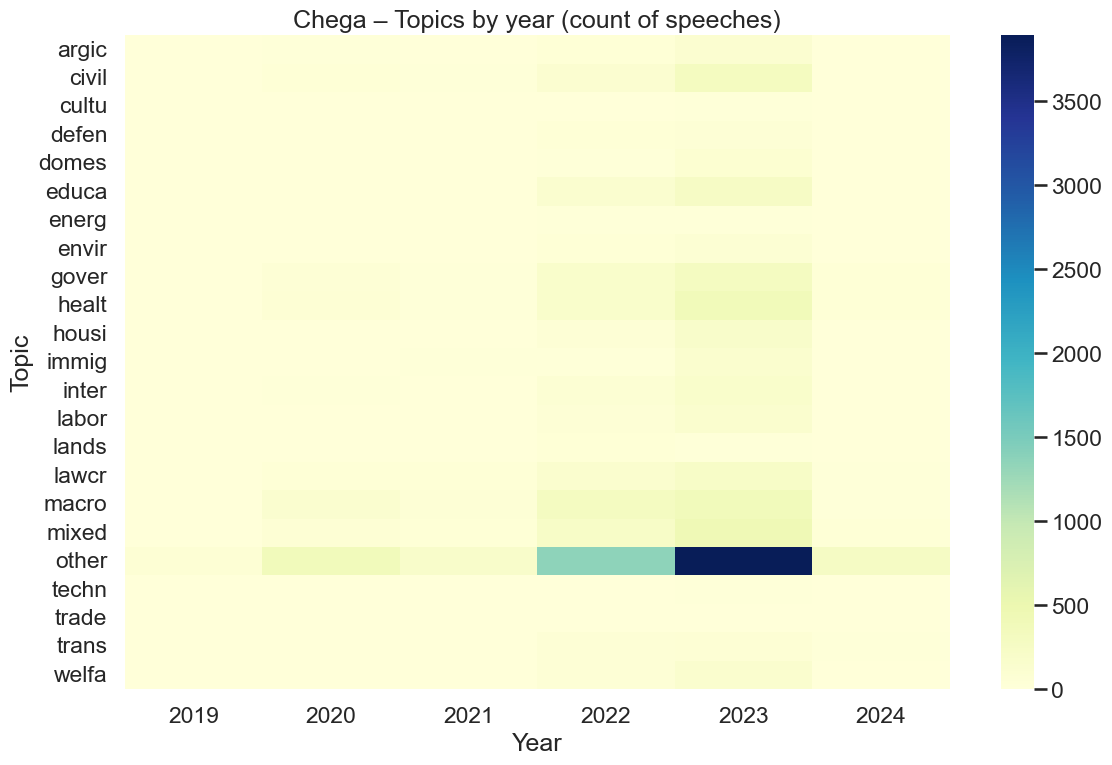

In [19]:
import re

def parse_speech_type(s):
    mode, topic = 'Unknown','Unknown'
    if isinstance(s, str):
        if '#chair' in s: mode = 'chair'
        elif '#regular' in s: mode = 'regular'
        m = re.search(r'topic:([A-Za-z\-]+)', s)
        if m: topic = m.group(1)
    return pd.Series({'mode':mode, 'topic':topic})

extra = ch['speech_type'].apply(parse_speech_type)
ch = ch.join(extra)

# Top topics overall
top_topics = ch['topic'].value_counts().head(15)
print("\nTop Chega topics (by number of speeches):")
print(top_topics.to_string())

# Topics by year (heatmap)
topic_year = (ch.dropna(subset=['year_num'])
                .groupby(['year_num','topic']).size()
                .reset_index(name='count'))
pivot = topic_year.pivot(index='topic', columns='year_num', values='count').fillna(0)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("Chega – Topics by year (count of speeches)")
plt.xlabel("Year"); plt.ylabel("Topic"); plt.tight_layout(); plt.show()


Still a work in progress.

### Analysis Shouts, Applauses and Interruptions


In [20]:
# Ensure year is numeric and drop unknowns for time-series
df_enriched["year_num"] = pd.to_numeric(df_enriched["year"], errors="coerce")

# Convenience: reaction totals and rates per 1k words
for col in ["applause_count","laughter_count","shout_count","interruption_count"]:
    rate_col = f"{col}_per_1k"
    df_enriched[rate_col] = 1000 * df_enriched[col] / df_enriched["word_count"].clip(lower=1)


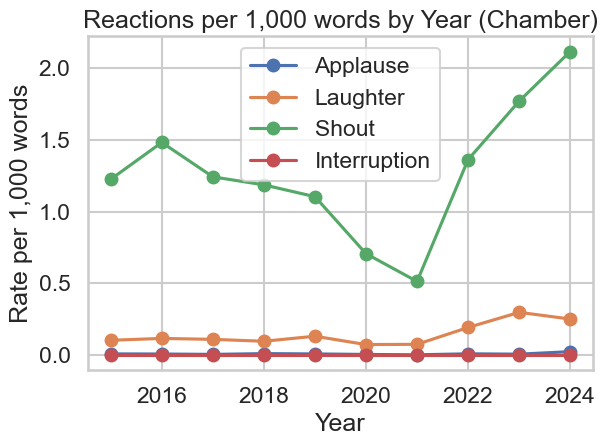

In [21]:
# 1) Chamber-level trends over time (are things getting more contentious?)
agg_year = (df_enriched
            .groupby("year_num", dropna=True)
            [["applause_count","laughter_count","shout_count","interruption_count","word_count"]]
            .sum())

rates_year = agg_year[["applause_count","laughter_count","shout_count","interruption_count"]].div(
    agg_year["word_count"].replace(0, np.nan), axis=0
) * 1000

plt.figure()
for col in ["applause_count","laughter_count","shout_count","interruption_count"]:
    plt.plot(rates_year.index, rates_year[col], marker="o", label=col.replace("_count","").title())
plt.xlabel("Year"); plt.ylabel("Rate per 1,000 words"); plt.title("Reactions per 1,000 words by Year (Chamber)")
plt.legend(); plt.tight_layout(); plt.show()


### Chamber-level trends over time (are things getting more contentious?)
The graph shows the number of reactions (applause, laughter, shouts, interruptions) per 1,000 spoken words over the years 2015-2024. This normalizes for speech volume, so we’re comparing intensity, not raw totals.

Observations:
- Shouts dominate: The green line (“Shout”) is much higher than all other reactions. Between 2015–2019, shouting steadily decreased (from ~1.5 per 1k words to ~0.5). After 2020, shouting surges dramatically, reaching ~2 per 1k words in 2024. Suggests the chamber has become more confrontational/polarized in recent legislatures.
- Laughter increases after 2021. Very low before 2020, but starting around 2021–22, laughter rates triple (from ~0.05 → 0.15 per 1k words). Possible sign of more sarcastic/performative debate styles.
- Interruptions are rare. The red line is close to zero across the whole period.
- Applause almost absent: The blue line hovers at ~0.0 the entire time.

How to read this politically:
- Pre-2020: Chamber becoming calmer (falling shouting rates).
- Post-2020: Sudden rise in hostility, with sharp growth in shouts and laughter — possibly linked to the entry of new radical/anti-establishment parties (e.g., Chega, IL) and pandemic-era debates that polarized discourse.

-> Implication: The Portuguese Parliament has shifted from relatively orderly debate (2015–2019) toward a more antagonistic, noisy, and performative style (2020 onwards).



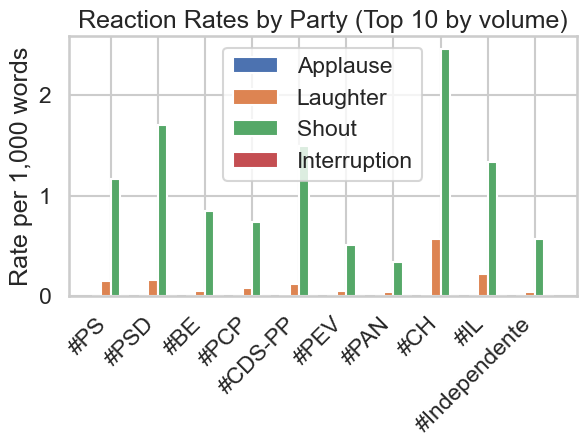

In [22]:
# 2) Party comparison (rates per 1,000 words)
agg_party = (df_enriched
             .groupby("party_name")[["applause_count","laughter_count","shout_count","interruption_count","word_count"]]
             .sum()
             .sort_values("word_count", ascending=False))

party_rates = agg_party[["applause_count","laughter_count","shout_count","interruption_count"]].div(
    agg_party["word_count"].replace(0, np.nan), axis=0
) * 1000

# Bar chart for each reaction type (top 10 parties by words)
top_parties = agg_party.head(10).index
subset = party_rates.loc[top_parties]

plt.figure()
width = 0.2
x = np.arange(len(subset.index))
for i, col in enumerate(["applause_count","laughter_count","shout_count","interruption_count"]):
    plt.bar(x + i*width, subset[col], width, label=col.replace("_count","").title())
plt.xticks(x + 1.5*width, subset.index, rotation=45, ha="right")
plt.ylabel("Rate per 1,000 words"); plt.title("Reaction Rates by Party (Top 10 by volume)")
plt.legend(); plt.tight_layout(); plt.show()


### Code to understand who reacts to whom

Reactions long table:                      speech_id speaker_party reacting_party event_type  count
0   ParlaMint-PT_2015-01-07.u6            BE        UNKNOWN   applause      1
1   ParlaMint-PT_2015-01-07.u8           PSD        UNKNOWN   applause      1
2  ParlaMint-PT_2015-01-07.u10           PCP        UNKNOWN   applause      1
3  ParlaMint-PT_2015-01-07.u12            PS        UNKNOWN   applause      1
4  ParlaMint-PT_2015-01-07.u14        CDS-PP        UNKNOWN   applause      1
Total reaction matrix:
 reacting_party    BE  CDS-PP    CH    IL    L  PAN   PCP  PEV     PS    PSD  \
speaker_party                                                                 
BE              6501     621   340    89   37   89   122    2    729   1099   
CDS-PP           625    6110    31    15    2   32   871   16   1060   1659   
CH               325       6  3761    59   79   19   248   19   1140    160   
IL                87      16   168  1590   57   20   158    3    498    109   
L           

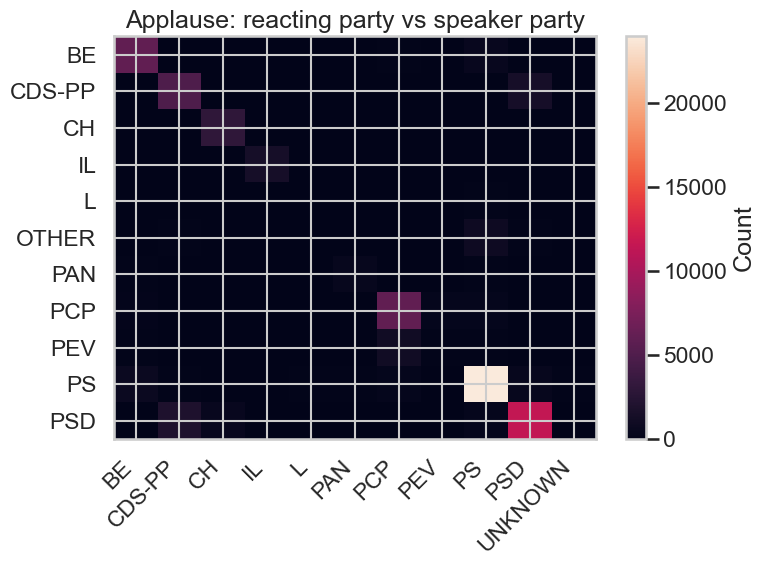

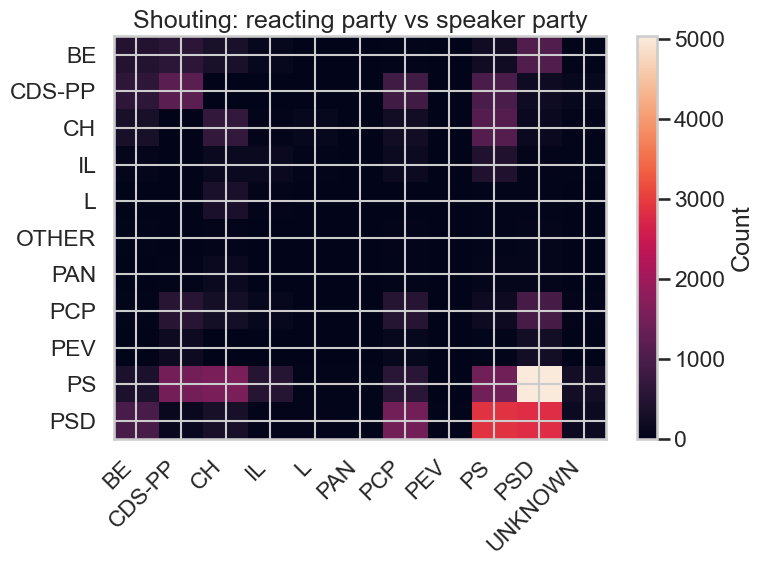

C:\Temp\ipykernel_23992\1901121228.py:246: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(data, aspect="auto")
C:\Temp\ipykernel_23992\1901121228.py:246: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(data, aspect="auto")


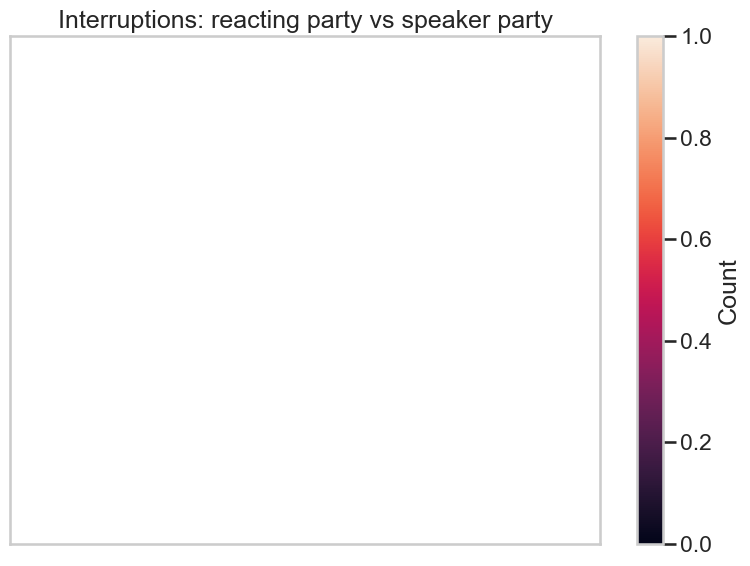

In [23]:
# --- BELOW YOUR EXISTING CODE ---

import re
from collections import defaultdict

# Canonical party codes we want to track (extend if needed)
PARTY_CODES = ["PS", "PSD", "CH", "IL", "PCP", "BE", "PAN", "L", "CDS-PP", "PEV"]

party_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, PARTY_CODES)) + r')\b')

def canon_party_from_text(text):
    """
    Extract a list of party codes from Portuguese <desc> like:
    'Aplausos do PS, do PSD e de Deputados da IL e do BE.'
    Returns unique codes preserving file order.
    """
    if not text:
        return []
    found = party_pattern.findall(text.upper())
    # keep order, remove dups
    seen = set()
    out = []
    for p in found:
        if p not in seen:
            seen.add(p)
            out.append(p)
    return out

def canon_party_from_who_attr(who_val):
    """
    who may be like '#CH' or '#PS #PSD' etc. Return list of codes sans '#'.
    Sometimes ParlaMint uses org IDs; if so, we try to match end tokens to PARTY_CODES.
    """
    if not who_val:
        return []
    # split by whitespace
    toks = [t.strip() for t in who_val.split() if t.strip()]
    out = []
    for t in toks:
        t = t.lstrip("#")
        # exact party code
        if t in PARTY_CODES:
            out.append(t)
            continue
        # try to extract trailing code (e.g., 'parla.party.PSD')
        m = party_pattern.search(t.upper())
        if m:
            out.append(m.group(0))
    # dedupe preserving order
    seen = set()
    uniq = []
    for p in out:
        if p not in seen:
            seen.add(p)
            uniq.append(p)
    return uniq

def canon_party_of_speaker(speaker_party_name, speaker_party_id):
    """
    Normalize the speaker's party to canonical code.
    Prefer a direct match; else try to mine the code from the party_id.
    Fallback to the display name uppercased if it's already a short code.
    """
    # direct
    if isinstance(speaker_party_name, str):
        up = speaker_party_name.strip().upper()
        if up in PARTY_CODES:
            return up
    # from id: e.g., '#parla.party.PSD'
    if isinstance(speaker_party_id, str):
        m = party_pattern.search(speaker_party_id.upper())
        if m:
            return m.group(0)
    # last resort: uppercase name if short
    if isinstance(speaker_party_name, str):
        up = speaker_party_name.strip().upper()
        if len(up) <= 6:
            return up
    return "OTHER"

# ----------------------------
# Build long table of reactions with reacting parties
# ----------------------------

reaction_rows = []  # long-format rows

for f in files:
    if "Schema" in f:
        continue
    try:
        tree = ET.parse(f)
        root = tree.getroot()

        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")
            if not speech_id:
                continue

            # Speaker party (canonical)
            speaker_id = u.attrib.get("who")
            speaker_id_clean = speaker_id.lstrip("#") if speaker_id else "Unknown"
            spk_info = speakers_dict.get(
                speaker_id_clean,
                {"party_id": "Unknown", "party_name": "Unknown"}
            )
            speaker_party = canon_party_of_speaker(spk_info.get("party_name"), spk_info.get("party_id"))

            # Helper to append reaction events (may be multi-source)
            def add_reaction(event_type, elem):
                # 1) from 'who' attribute on the reaction element
                r_from_who = []
                who_attr = elem.attrib.get("who")
                if who_attr:
                    r_from_who = canon_party_from_who_attr(who_attr)

                # 2) from <desc> free text
                desc_text = "".join(elem.itertext()).strip() if elem is not None else ""
                r_from_desc = canon_party_from_text(desc_text)

                # union preserving order: prefer explicit 'who' first
                merged = []
                seen = set()
                for lst in (r_from_who, r_from_desc):
                    for p in lst:
                        if p not in seen:
                            seen.add(p)
                            merged.append(p)

                # If we still have no reacting party, we can record UNKNOWN reaction
                if not merged:
                    merged = ["UNKNOWN"]

                for reacting_party in merged:
                    reaction_rows.append({
                        "speech_id": speech_id,
                        "speaker_party": speaker_party,
                        "reacting_party": reacting_party,
                        "event_type": event_type,
                        "count": 1
                    })

            # <kinesic> (includes applause)
            for kin in u.findall(".//{*}kinesic"):
                kin_type = (kin.attrib.get("type") or kin.attrib.get("ana") or "").lower()
                if "applause" in kin_type or "aplauso" in kin_type:
                    add_reaction("applause", kin)
                else:
                    # you could track other kinesic types if needed
                    pass

            # <vocal> (shouting, laughter, protests, cheers, etc.)
            for voc in u.findall(".//{*}vocal"):
                v_type = (voc.attrib.get("type") or voc.attrib.get("ana") or "").lower()
                # Map a few common ones; extend as needed
                if "shout" in v_type or "protest" in v_type:
                    add_reaction("shouting", voc)
                elif "laugh" in v_type or "risos" in v_type or "riso" in v_type:
                    add_reaction("laughter", voc)
                elif "applause" in v_type or "aplauso" in v_type:
                    add_reaction("applause", voc)
                else:
                    # Unknown vocal event; skip or track as 'vocal_other'
                    pass

            # <incident> (interruptions, noise)
            for inc in u.findall(".//{*}incident"):
                i_type = (inc.attrib.get("type") or inc.attrib.get("ana") or "").lower()
                if "interrupt" in i_type or "interrup" in i_type:
                    add_reaction("interruption", inc)
                else:
                    # incident_other if you want to analyze later
                    pass

    except Exception as e:
        print(f"⚠️ Error extracting reacting parties in {f}: {e}")

# Long DataFrame of reactions
reactions_long = pd.DataFrame(reaction_rows)
print("Reactions long table:", reactions_long.head())

# ----------------------------
# Build matrices
# ----------------------------

# Total reactions matrix (all event types)
reaction_matrix_total = (reactions_long
                         .pivot_table(index="speaker_party", columns="reacting_party",
                                      values="count", aggfunc="sum", fill_value=0)
                         .sort_index())
print("Total reaction matrix:\n", reaction_matrix_total)

# By event type (e.g., applause-only / shouting-only / interruption-only)
reaction_matrix_applause = (reactions_long[reactions_long["event_type"]=="applause"]
                            .pivot_table(index="speaker_party", columns="reacting_party",
                                         values="count", aggfunc="sum", fill_value=0)
                            .sort_index())

reaction_matrix_shouting = (reactions_long[reactions_long["event_type"]=="shouting"]
                            .pivot_table(index="speaker_party", columns="reacting_party",
                                         values="count", aggfunc="sum", fill_value=0)
                            .sort_index())

reaction_matrix_interrupt = (reactions_long[reactions_long["event_type"]=="interruption"]
                             .pivot_table(index="speaker_party", columns="reacting_party",
                                          values="count", aggfunc="sum", fill_value=0)
                             .sort_index())

print("Applause matrix:\n", reaction_matrix_applause)
print("Shouting matrix:\n", reaction_matrix_shouting)
print("Interruption matrix:\n", reaction_matrix_interrupt)

# ----------------------------
# Optional: normalize by how much each party speaks (per 1,000 words)
# ----------------------------

# Speaker party total words (from df_enriched)
if "df_enriched" in globals():
    words_by_party = (df_enriched.groupby("party_name")["word_count"].sum())
    # normalize keys to canonical codes
    words_by_party.index = [canon_party_of_speaker(pn, pn) for pn in words_by_party.index]
    # ensure we have all codes present
    words_by_party = words_by_party.groupby(words_by_party.index).sum()

    def per_1k_words(mat):
        aligned = mat.copy()
        # divide each row (speaker party) by its total words / 1000
        denom = (words_by_party / 1000.0).reindex(aligned.index)
        return aligned.div(denom, axis=0)

    reaction_matrix_total_per1k = per_1k_words(reaction_matrix_total)
    reaction_matrix_applause_per1k = per_1k_words(reaction_matrix_applause)
    reaction_matrix_shouting_per1k = per_1k_words(reaction_matrix_shouting)
    reaction_matrix_interrupt_per1k = per_1k_words(reaction_matrix_interrupt)

    print("Total reactions per 1,000 words:\n", reaction_matrix_total_per1k.round(2))

# ----------------------------
# Optional: quick heatmap plot (matplotlib only)
# ----------------------------
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(mat, title):
    plt.figure(figsize=(8, 6))
    data = mat.values.astype(float)
    plt.imshow(data, aspect="auto")
    plt.colorbar(label="Count")
    plt.xticks(ticks=np.arange(mat.shape[1]), labels=mat.columns, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(mat.shape[0]), labels=mat.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(reaction_matrix_applause, "Applause: reacting party vs speaker party")
plot_heatmap(reaction_matrix_shouting, "Shouting: reacting party vs speaker party")
plot_heatmap(reaction_matrix_interrupt, "Interruptions: reacting party vs speaker party")


*Interpretation:*

Parties tend to applause to their own parties mainly.

key observations on the shouting trends:
- PS (Socialist Party) as a main target
    - The darkest cells are in the PS column, especially when PSD MPs and “UNKNOWN” (unclassified shouts) react.
    - This means PS speeches trigger the most shouting, which makes sense since PS has been in government for most of the period and thus is the main target of opposition attacks.
- PSD (Social Democrats) also targeted
    - Significant shouting occurs against PSD speakers, particularly from PS MPs.
    - This reflects the traditional government-opposition dynamic between the two big parties.
- Opposition parties reacting strongly
    - BE, PCP, CDS-PP all show moderate shouting directed at PS speeches.
    - Their smaller but clear presence suggests they actively use vocal reactions as a tactic against the governing party.
- Chega (CH)
    - Appears both as speaker and reactor, but the intensity is lower than the PS–PSD shouting exchanges.
    - This may reflect its newer parliamentary presence: Chega contributes to noise, but the traditional

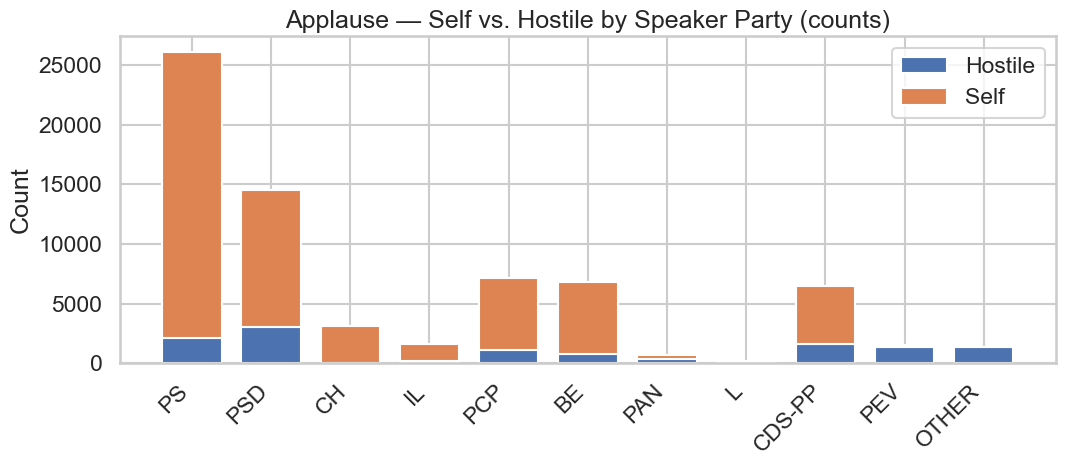

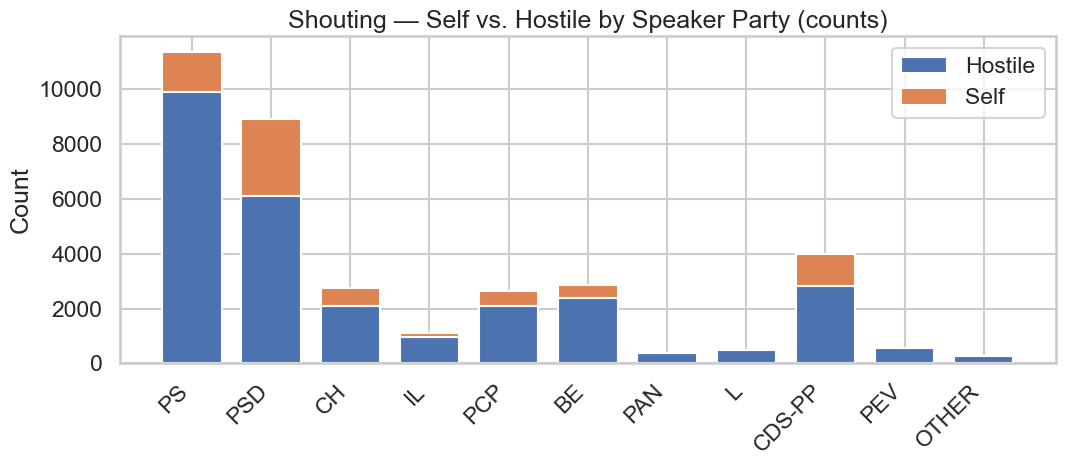

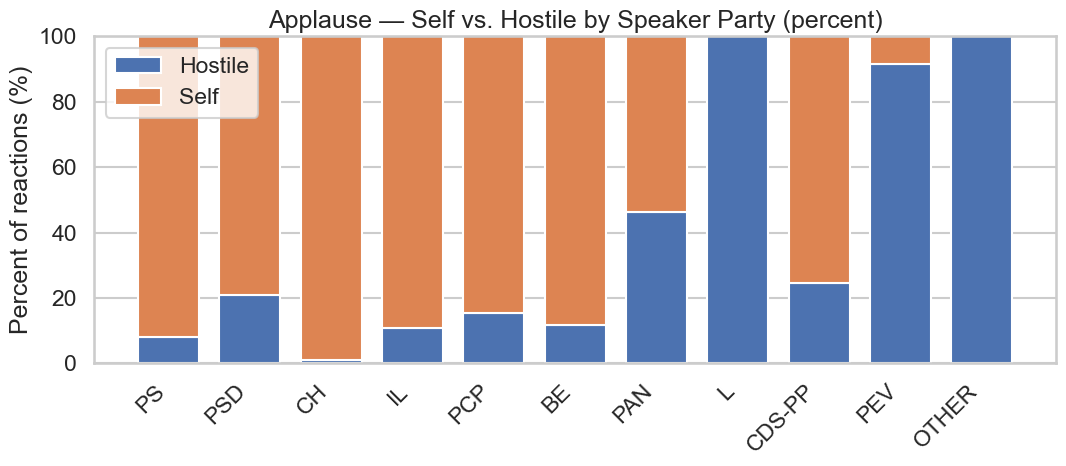

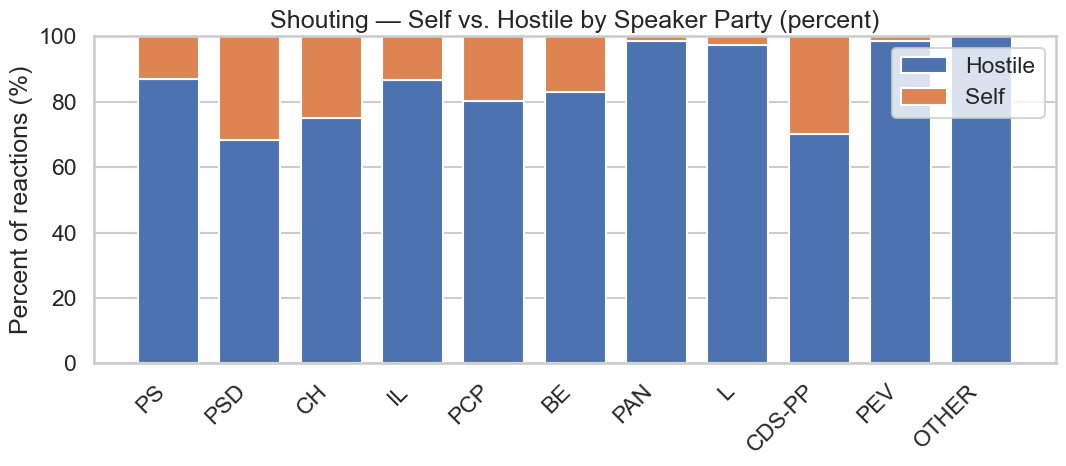

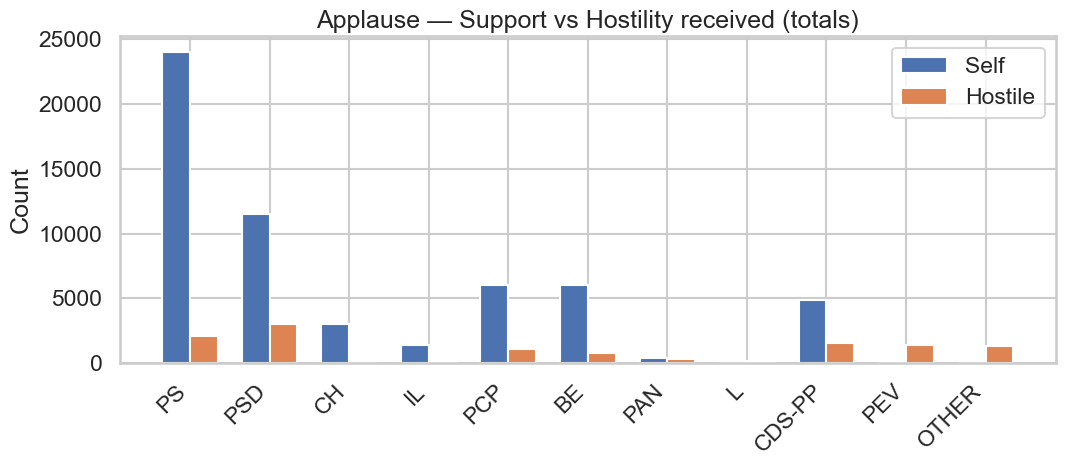

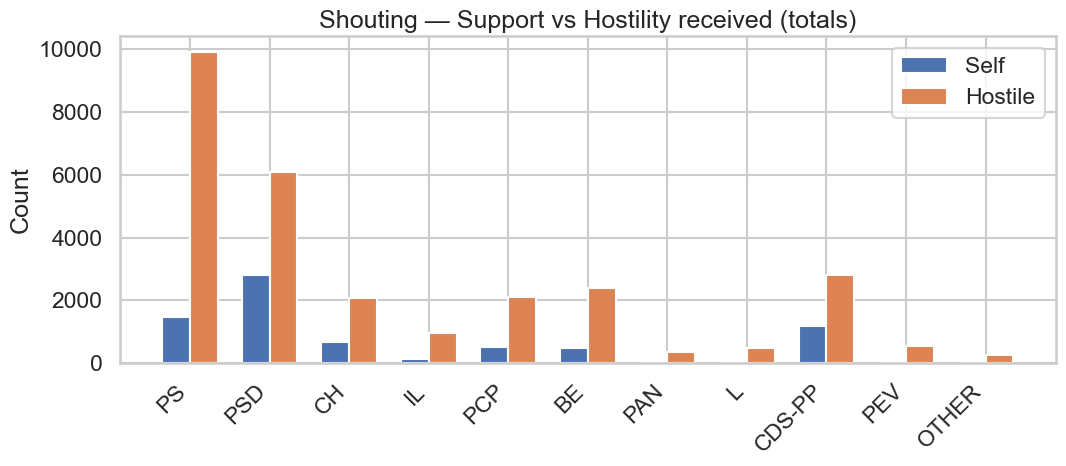

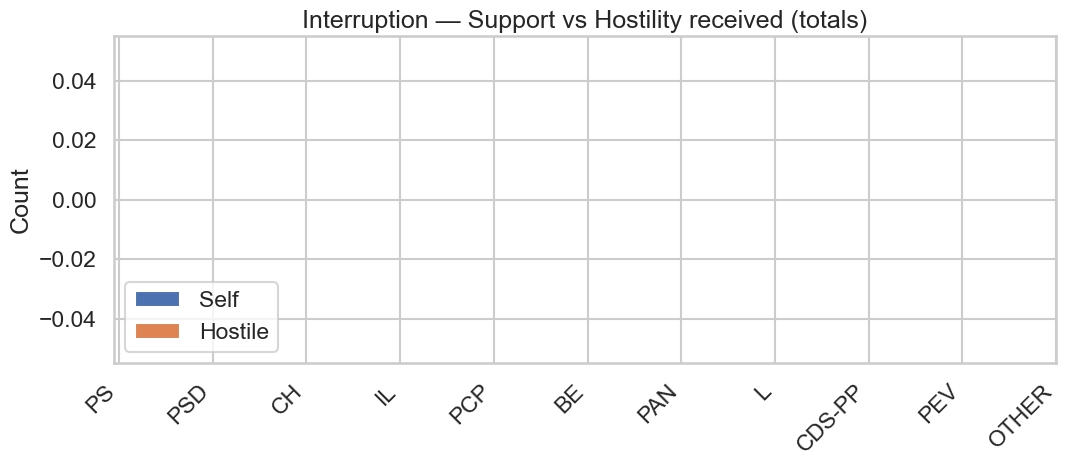

In [25]:
# Self-reactions vs hostile reactions

# =========================
# Self vs. Hostile — per party, graphed
# =========================
import matplotlib.pyplot as plt
import numpy as np

# Ensure we have a clean party order on the x-axis
ALL_PARTIES = PARTY_CODES + ["OTHER", "UNKNOWN"]
def sort_cols(idx):
    order = [p for p in ALL_PARTIES if p in idx]
    # append any unexpected labels at the end
    order += [p for p in idx if p not in order]
    return order

# (A) Build self/hostile table per party and event
tbl = (reactions_long
       .assign(self_reaction=lambda d: d["speaker_party"] == d["reacting_party"])
       .groupby(["event_type","speaker_party","self_reaction"])["count"]
       .sum()
       .unstack(fill_value=0)
       .rename(columns={False:"Hostile", True:"Self"})
       .reset_index())

# Optional: normalize by words spoken (per 1k) — set to True if you want it
NORMALIZE_PER_1K_WORDS = False
if NORMALIZE_PER_1K_WORDS and "df_enriched" in globals():
    words_by_party = (df_enriched.groupby("party_name")["word_count"].sum())
    words_by_party.index = [canon_party_of_speaker(pn, pn) for pn in words_by_party.index]
    words_by_party = words_by_party.groupby(words_by_party.index).sum() / 1000.0  # per 1k words
    tbl["denom"] = tbl["speaker_party"].map(words_by_party).fillna(1.0)
    tbl["Self"]   = tbl["Self"]   / tbl["denom"]
    tbl["Hostile"]= tbl["Hostile"]/ tbl["denom"]

# (B) Helper to plot stacked bars for each event type
def plot_stacked_by_event(df, value_label, title_suffix=""):
    events = ["applause","shouting","interruption"]
    for ev in events:
        sub = df[df["event_type"]==ev].copy()
        if sub.empty:
            continue
        # ensure consistent party ordering
        parties = sort_cols(sub["speaker_party"].tolist())
        sub = sub.set_index("speaker_party").reindex(parties)

        x = np.arange(len(sub))
        width = 0.75
        fig, ax = plt.subplots(figsize=(11,5))
        ax.bar(x, sub["Hostile"], width, label="Hostile")
        ax.bar(x, sub["Self"], width, bottom=sub["Hostile"], label="Self")
        ax.set_xticks(x)
        ax.set_xticklabels(sub.index, rotation=45, ha="right")
        ax.set_ylabel(value_label)
        ax.set_title(f"{ev.capitalize()} — Self vs. Hostile by Speaker Party{title_suffix}")
        ax.legend()
        plt.tight_layout()
        plt.show()

# (C) Raw counts stacked
plot_stacked_by_event(tbl, value_label="Count", title_suffix=" (counts)")

# (D) Percent share stacked (Self% vs Hostile%)
tbl_pct = tbl.copy()
tot = (tbl_pct[["Self","Hostile"]].sum(axis=1)).replace(0, np.nan)
tbl_pct["Self"]    = tbl_pct["Self"]   / tot * 100
tbl_pct["Hostile"] = tbl_pct["Hostile"]/ tot * 100
plot_stacked_by_event(tbl_pct, value_label="Percent of reactions (%)", title_suffix=" (percent)")

# (E) Optional: quick leaderboard bars — which parties receive the most hostility/support?
summary = (tbl.groupby(["event_type","speaker_party"])[["Self","Hostile"]]
             .sum().reset_index())
for ev in ["applause","shouting","interruption"]:
    s = summary[summary["event_type"]==ev].set_index("speaker_party").reindex(sort_cols(summary["speaker_party"].unique()))
    # two side-by-side bars per party
    x = np.arange(len(s)); w = 0.35
    fig, ax = plt.subplots(figsize=(11,5))
    ax.bar(x - w/2, s["Self"], width=w, label="Self")
    ax.bar(x + w/2, s["Hostile"], width=w, label="Hostile")
    ax.set_xticks(x); ax.set_xticklabels(s.index, rotation=45, ha="right")
    ax.set_title(f"{ev.capitalize()} — Support vs Hostility received (totals)")
    ax.set_ylabel("Count" if not NORMALIZE_PER_1K_WORDS else "Per 1k words")
    ax.legend(); plt.tight_layout(); plt.show()


*Interpretation:*

These graphs divide the reaction between Self and Hostile. This separate when a party applauds/shouts its own speaker vs when reactions come from other parties. This lets us quantify self-support vs opposition attacks.

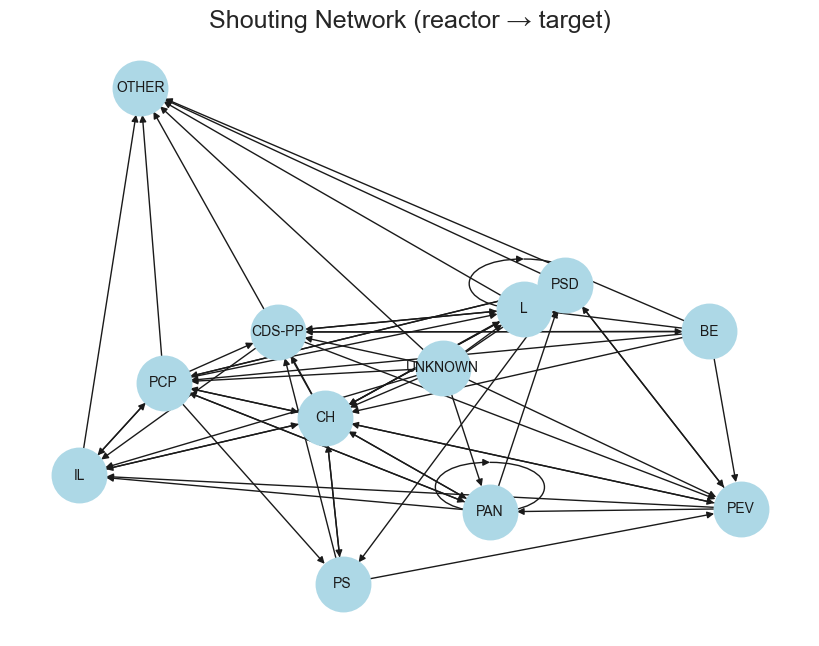

In [27]:
# Network Visualization
import networkx as nx

G = nx.DiGraph()
for _, row in reactions_long.iterrows():
    G.add_edge(row["reacting_party"], row["speaker_party"],
               weight=row["count"], event=row["event_type"])

# Example: visualize shouting subgraph
shout_edges = [(u,v,d["weight"]) for u,v,d in G.edges(data=True) if d["event"]=="shouting"]
H = nx.DiGraph()
H.add_weighted_edges_from(shout_edges)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(H, k=0.5, seed=42)
nx.draw(H, pos, with_labels=True, node_size=1500, node_color="lightblue", font_size=10, width=1)
plt.title("Shouting Network (reactor → target)")
plt.show()


*Interpretation:*

Network visualization is a directed graph of who reacts to whom (applause vs shouting). It gives an intuitive map of alliances and antagonisms.